# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Mini-Projeto 6</font>
## <font color='blue'>Zero Shot Learning Para Detecção de Objetos com OpenAI CLIP</font>

https://huggingface.co/openai/clip-vit-base-patch32

![DSA](imagens/MP6.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.4


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
!pip install -q tensorflow==2.14.0

In [4]:
!pip install -q torch==2.0.1

In [5]:
!pip install -q torchvision==0.15.2

In [6]:
!pip install -q transformers

In [7]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [9]:
# Imports
import os
import torch
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

tensorflow : 2.14.0
numpy      : 1.24.3
torch      : 2.0.1
torchvision: 0.15.2
PIL        : 9.4.0
matplotlib : 3.7.1



## Verificando o Device

In [11]:
if torch.cuda.is_available():
    print('Número de GPUs:', torch.cuda.device_count())
    print('Modelo GPU:', torch.cuda.get_device_name(0))
    print('Total Memória [GB] da GPU:',torch.cuda.get_device_properties(0).total_memory / 1e9)

Número de GPUs: 1
Modelo GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Total Memória [GB] da GPU: 8.361017344


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
print(device)

cuda


## Zero-Shot Learning (ZSL)

Zero-Shot Learning (ZSL) é um tipo de aprendizado em que um modelo é ajustado para reconhecer classes que não viu durante o treinamento. Na detecção de objetos, isso é particularmente desafiador devido à necessidade de não apenas classificar, mas também localizar objetos. Uma estratégia comum para ZSL é usar embeddings semânticos (como word embeddings) para relacionar classes conhecidas e desconhecidas. 

## Carregando a Imagem

In [14]:
# Imagem
imagem = Image.open("dados/imagem.jpg")

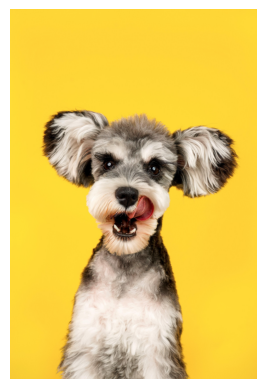

In [15]:
# Plot da imagem
plt.imshow(imagem)
plt.axis('off')
plt.show()

## Pré-Processamento

In [16]:
# Função para transformar a imagem em tensor
transt = transforms.ToTensor()

In [17]:
# Aplica a função
img = transt(imagem)

In [18]:
# Shape
img.data.shape

torch.Size([3, 4243, 2831])

In [19]:
# Adiciona dimensão de lote (batch) e mudar a dimensão de canais de cores
patches = img.data.unfold(0,3,3)
patches.shape

torch.Size([1, 4243, 2831, 3])

In [20]:
# Divide a imagem em patches na dimensão de altura
patch = 256
new_patches = patches.unfold(1, patch, patch)
new_patches.shape

torch.Size([1, 16, 2831, 3, 256])

In [21]:
# Divide a imagem em patches na dimensão de largura
new_patches_1 = new_patches.unfold(2, patch, patch)
new_patches_1.shape

torch.Size([1, 16, 11, 3, 256, 256])

## Modelagem com OpenAI CLIP

https://huggingface.co/openai/clip-vit-base-patch32

In [22]:
# Define o modelo
modelo_id = "openai/clip-vit-base-patch32"

In [23]:
# Carrega o modelo
modelo = CLIPModel.from_pretrained(modelo_id)

In [24]:
# Carrega o processador do modelo
processor = CLIPProcessor.from_pretrained(modelo_id)

In [25]:
# Manda o modelo para o device
modelo.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## Usando o Modelo Para Extrair os Scores (Classificações)

In [26]:
# Hiperparâmetros
window = 6
stride = 1

In [27]:
# Variáveis de métricas
scores = torch.zeros(new_patches_1.shape[1], new_patches_1.shape[2])
runs = torch.ones(new_patches_1.shape[1], new_patches_1.shape[2])

In [28]:
# Iniciar loop principal para percorrer o eixo Y dos patches
for Y in range(0, new_patches_1.shape[1]-window+1, stride):
    
    # Iniciar loop secundário para percorrer o eixo X dos patches
    for X in range(0, new_patches_1.shape[2]-window+1, stride):
        
        # Inicializar um tensor vazio para armazenar os patches combinados de maior tamanho
        big_patch = torch.zeros(patch*window, patch*window, 3)
        
        # Extrair uma janela de patches da posição atual (Y, X)
        patch_batch = new_patches_1[0, Y:Y+window, X:X+window]
        
        # Iterar sobre a dimensão y da janela de patches
        for y in range(window):
            
            # Iterar sobre a dimensão x da janela de patches
            for x in range(window):
                
                # Reordenar e colocar cada patch pequeno na posição correta dentro do big_patch
                big_patch[y*patch:(y+1)*patch, x*patch:(x+1)*patch, :] = patch_batch[y, x].permute(1, 2, 0)
        
        # Processar o big_patch para transformá-lo em um tensor compatível com PyTorch 
        # e movê-lo para o device 
        inputs = processor(images = big_patch, return_tensors = "pt", text = "an animal", padding = True).to(device)

        # Usar o modelo para obter um score para o big_patch
        score = modelo(**inputs).logits_per_image.item()

        # Atualizar a matriz de scores com o score obtido para a janela atual
        scores[Y:Y+window, X:X+window] += score

        # Incrementar a contagem na matriz runs para cada posição na janela atual
        runs[Y:Y+window, X:X+window] += 1

## Preparando as Bounding Boxes Para Visualização a Partirs dos Scores

In [29]:
# Scores divididos pelos runs
scores /= runs

In [30]:
# Clip dos scores
# Essa operação garante que todos os valores em scores sejam não negativos e que 
# valores abaixo da média original sejam definidos como zero.
scores = np.clip(scores - scores.mean(), 0, np.inf)

In [31]:
# Normaliza os scores
scores = (scores - scores.min()) / (scores.max() - scores.min())

In [32]:
# Shapes
scores.shape, new_patches_1.shape

(torch.Size([16, 11]), torch.Size([1, 16, 11, 3, 256, 256]))

In [33]:
# Transforma os patches em tensor
adj_patches = new_patches_1.squeeze(0).permute(3, 4, 2, 0, 1)
adj_patches.shape

torch.Size([256, 256, 3, 16, 11])

In [34]:
# Multiplica os patches pelos scores
adj_patches = adj_patches * scores

In [35]:
# Rotaciona os patches para visualizar
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)
adj_patches.shape

torch.Size([16, 11, 3, 256, 256])

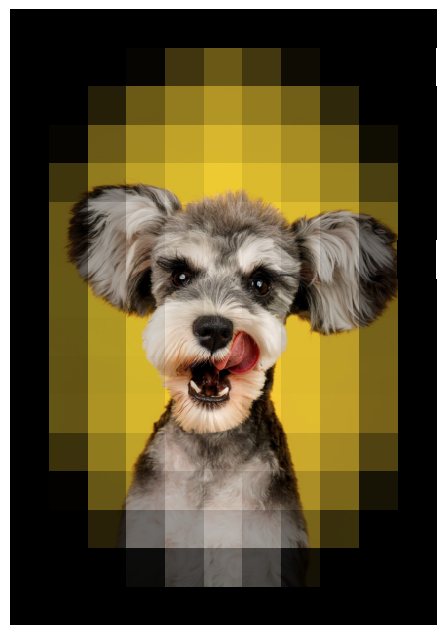

In [36]:
# Visualizando todas as bounding boxes

# X e Y
Y = adj_patches.shape[0]
X = adj_patches.shape[1]

# Plot
fig, ax = plt.subplots(Y, X, figsize = (X*.5, Y*.5))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.savefig('dados/imagem_bbox.png')
plt.show()

## Imagem Final com a Bounding Box de Maior Probabilidade na Classificação

In [37]:
# Somente scores maiores que 0.50 serão considerados detecção
detection = scores > 0.5

In [38]:
# Coordenadas mínimas de y para a bbox
y_min, y_max = (np.nonzero(detection)[:,0].min().item(), np.nonzero(detection)[:,0].max().item()+1)
y_min, y_max

(2, 14)

In [39]:
# Coordenadas máximas de x para a bbox
x_min, x_max = (np.nonzero(detection)[:,1].min().item(), np.nonzero(detection)[:,1].max().item()+1)
x_min, x_max

(2, 9)

In [40]:
# Incluímos o pacth
y_min *= patch
y_max *= patch
x_min *= patch
x_max *= patch
x_min, y_min

(512, 512)

In [41]:
# Altura e largura da bbox
height = y_max - y_min
width = x_max - x_min

In [42]:
height, width

(3072, 1792)

In [43]:
# Shape da imagem original
img.data.numpy().shape

(3, 4243, 2831)

In [44]:
# Move a dimensão do canal de cor para o final
image = np.moveaxis(img.data.numpy(), 0, -1)
image.shape

(4243, 2831, 3)

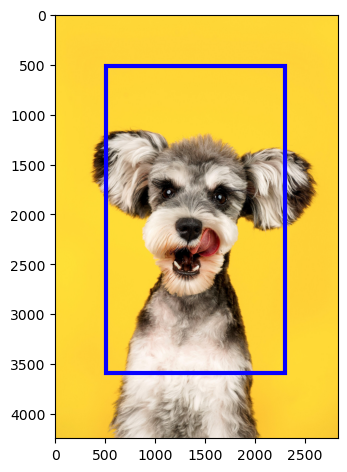

In [45]:
# Imprime a imagem e a bounding box
import matplotlib.patches as patches

# Figura
fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))

# Imagem original
ax.imshow(image)

# Cria o retângulo da bbox
rect = patches.Rectangle((x_min, y_min), width, height, linewidth = 3, edgecolor = '#0800ff', facecolor = 'none')

# Adiciona o patch ao plot
ax.add_patch(rect)

plt.savefig('dados/imagem_final.png')
plt.show()

# Fim